In [11]:
import numpy as np
import cvxpy as cp
import copy
import matplotlib.pyplot as plt


np.set_printoptions(precision=2)

Mao, Y., Szmuk, M., & Acikmese, B. (2018). Successive Convexification: A Superlinearly Convergent Algorithm for Non-convex Optimal Control Problems. arXiv preprint arXiv:1804.06539.

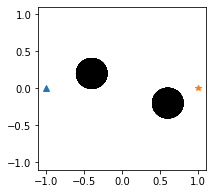

In [12]:
dt, N = 0.1, 30 # Time discretization
na = 2 # Number of agents
nx = 4 # Number of states per agent
nu = 2 # Number of actions per agent
nobs = 2

# Double integrator
_n = int(nx/2)
A_np = np.block([[np.eye(_n), dt * np.eye(_n)],
                 [np.zeros((_n,_n)), np.eye(_n)]])

B_np = np.block([[0.5*dt**2 * np.eye(_n)], 
                 [dt*np.eye(_n)]])

T = np.block([np.eye(2), np.zeros((2,2))])

# Quadratic costs
Q_np = np.eye(nx)
R_np = np.eye(nu)

x_inits = [np.array([-1,0,0,0]), np.array([0,-1,0,0])]
x_dess  = [np.array([1,0,0,0]), np.array([0,1,0,0])]

# State and control constraints
u_max = 2
ns = nobs + na - 1

# Obstacles
__x_obs = [np.array([-0.4,  0.2]), np.array([ 0.6, -0.2])]#, np.array([0.,0])]
__r_obs = [np.array([0.2]), np.array([0.2])]#, np.array([.1])]
r_buffer = .1
nobs = len(__x_obs)

x_obs = [copy.deepcopy(__x_obs) for i in range(N)]
r_obs = [copy.deepcopy(__r_obs) for i in range(N)]

def setup_fig(x_obs, r_obs, x_des, x_init):
    fig, ax = plt.subplots(figsize=(3,3))
    plt.plot(*x_des[:2],'^',label='destination')
    plt.plot(*x_init[:2],'*',label='initial')
    _t = np.linspace(0,2*np.pi,25)
    for i in range(N):
        for j in range(nobs):
            _circ = plt.Circle(x_obs[i][j], r_obs[i][j], color='k', alpha=1)
            ax.add_artist(_circ)
        for j in range(nobs,ns):
            plt.plot(r_obs[i][j] * np.cos(_t) + x_obs[i][j][0], r_obs[i][j] * np.sin(_t) + x_obs[i][j][1],'--k')
#     plt.legend()
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    
def append_obs(x_obs, r_obs, xs, r):
    x_obs = copy.deepcopy(x_obs)
    r_obs = copy.deepcopy(r_obs)
    _n = len(xs)
    for i in range(N):
        x_obs[i] += [xs[k][i] for k in range(_n)]
        r_obs[i] += [np.array([r]) for k in range(_n)]
    return x_obs, r_obs

    
_x_a = [np.ones((N,2))*x_obs[0][0] for _ in range(na-1)]
_x_obs, _r_obs = append_obs(x_obs, r_obs, _x_a, r_buffer)

setup_fig(_x_obs, _r_obs, x_inits[0], x_dess[0])
plt.show()

$$L ^ { k } ( d , w ) : = C \left( x ^ { k } + d , u ^ { k } + w \right) + \sum _ { i = 1 } ^ { N - 1 } \lambda _ { i } P \left( E _ { i } v _ { i } , s _ { i } ^ { \prime } \right)$$

In [13]:
''' Successive Convexification: SCvx '''

''' Define costs '''

cost = lambda x,u: sum([cp.quad_form(x[i],Q_np) + cp.quad_form(u[i],R_np) 
                        for i in range(N-1)]) + cp.quad_form(x[-1],Q_np)
cost_np = lambda x,u: sum([x[i].T @ Q_np @ x[i] + u[i].T @ R_np @ u[i] 
                           for i in range(N-1)]) + x[-1].T @ Q_np @ x[-1]

cost = lambda x,u: sum([cp.quad_form(u[i],R_np) 
                        for i in range(N-1)])
cost_np = lambda x,u: sum([u[i].T @ R_np @ u[i] 
                           for i in range(N-1)])

''' Non-convex dynamics and constraints '''
f = lambda xi,ui: A_np @ xi + B_np @ ui

nv = nx
ns = nobs + na - 1
nq = 1
E = np.eye(nx) #np.zeros((nx,nv))
λ = 1e8*np.ones((N-1))


d = cp.Variable((N,nx))
w = cp.Variable((N-1,nu))
v = cp.Variable((N-1,nv))
sp = cp.Variable((N-1,ns))

xN = cp.Parameter((nx))
x = cp.Parameter((N,nx))
u = cp.Parameter((N-1,nu))
trust = cp.Parameter()
s_true = cp.Parameter((N-1,ns))
f_xu = cp.Parameter((N-1, nx))

A = [cp.Parameter((nx, nx)) for _ in range(N-1)]
B = [cp.Parameter((nx, nu)) for _ in range(N-1)]
S = [cp.Parameter((ns, nx)) for _ in range(N-1)]
Q = [cp.Parameter((nq, nu)) for _ in range(N-1)]

x.value = np.zeros((N,nx))
u.value = np.zeros((N-1,nu))
f_xu.value = np.zeros((N-1,nx))

penality_constraint = lambda x: cp.sum(cp.pos(x))
penality_constraint_np = lambda x: np.sum(np.maximum(0,x))
penality_dynamics = lambda x: cp.sum(cp.abs(x))
penality_dynamics_np = lambda x: np.sum(np.abs(x))

# Loss function with penality
PL = [penality_dynamics(E @ v[i]) + penality_constraint(sp[i]) for i in range(N-1)]
L = cost(x+d,u+w) + cp.sum([λ[i] * PL[i] for i in range(N-1)])

constraints = []

# Initial and final states
constraints += [d[0] == np.zeros((nx))] # initial state info already in x
constraints += [x[-1] + d[-1] == xN]

# Covexified dynamics and state constraints
constraints += [x[i+1] + d[i+1] == f_xu[i] + A[i] @ d[i] + B[i] @ w[i] + E @ v[i]
                 for i in range(N-1)]
constraints += [s_true[i] + S[i] @ d[i] + Q[i] @ w[i] - sp[i] <= 0 
                  for i in range(N-1)]
constraints += [sp[i] >= 0 for i in range(N-1)]
#constraints += [cp.abs(u[i] + w[i]) <= u_max for i in range(N-1)]
# Trust region
constraints += [sum([cp.norm(w[i],2) + cp.norm(d[i],2) for i in range(N-1)]) <= trust ]

In [14]:


def cvx(x_init, x_des):
    x.value[0] = x_init
    xN.value = x_des
    for i in range(N-1):
        A[i].value = A_np # (nx, nx)
        B[i].value = B_np # (nx, nu)
        S[i].value = np.zeros((ns, nx))
        Q[i].value = np.zeros((nq, nu))
        f_xu.value[i] = np.zeros((nx))
    s_true.value = np.zeros((N-1,ns))
    trust.value = 10000
    prob = cp.Problem(cp.Minimize(L), constraints)
    sol = prob.solve(solver='SCS') 
    
    return copy.copy(x.value+d.value), copy.copy(u.value+w.value) 
  

In [15]:
config_scvx_default = dict(
    ρ0 = 0,
    ρ1 = .25,
    ρ2 = .8,
    r0 = 1,
    α = 2,
    β = 3.2,
    tol = 1e-1,
    pen_tol = 1e-4,
    num_iters = 100)

def scvx(x_init, x_des, x_obs, r_obs, \
         ρ0, ρ1,  ρ2,  r0,  α ,  β , tol, pen_tol, num_iters, \
         _x=np.zeros((N,nx)), _u=np.zeros((N-1,nu)), trial=0, ):
    r = [r0]
    ρ = [ρ0]
    
    x.value = _x
    u.value = _u
    
    x.value[0] = x_init
    xN.value = x_des
    for _i in range(num_iters):
        print('---')
        ''' Step 1: Solve Problem 2'''
        # Evaluate zeroth order and first order at current (x^k,u^k)
        s_helper = lambda i,j,x,u: -(np.linalg.norm(T @ x[i] - x_obs[i][j])**2 - (r_obs[i][j] + r_buffer)**2)
        ds_helper = lambda i,j,x,u: -2*T.T @ (T @ x[i] - x_obs[i][j])

        s = lambda x,u: np.block([[s_helper(i, j, x, u) for j in range(ns)] # or x[i+1]?
                                                           for i in range(N-1)])
        ds = lambda i,x,u: np.block([[ds_helper(i, j, x, u)] for j in range(ns)])
        s_np = s(x.value, u.value)
        ds_np = [ds(i, x.value, u.value) for i in range(N-1)]

        # Set linearized parameters
        s_true.value = s_np
        for i in range(N-1):
            A[i].value = A_np
            B[i].value = B_np
            S[i].value = ds_np[i]
            Q[i].value = np.zeros((nq,nu))
            f_xu.value[i] = f(x.value[i], u.value[i]) 
        trust.value = r[-1]

        prob = cp.Problem(cp.Minimize(L), constraints)
        sol = prob.solve(solver='SCS',warm_start= True if _i != 0 else False)
        print('status', prob.status)

        ''' Step 2: actual and predicted change '''
        PJ = lambda x,u: [penality_dynamics_np(x[i+1] - f(x[i],u[i])) + penality_constraint_np(s_np[i]) 
                          for i in range(N-1)]

        J = lambda x,u: cost_np(x,u) + sum([λ[i] * _pj[i]
                                            for i in range(N-1)
                                            for _pj in [PJ(x,u)]])

        # Actual change
        DJ = J(x.value, u.value) - J(x.value + d.value, u.value + w.value)
        DL = J(x.value, u.value) - L.value

        _penality = sum(PJ(x.value, u.value))
        print('DL:          ',DL)
        print('actual cost: ', cost_np(x.value, u.value))
        print('penality     ', _penality)

        if np.allclose(DL, 0, rtol=tol, atol=tol) and \
           np.allclose(_penality, 0, rtol=pen_tol, atol=pen_tol): break
        ρ.append(DJ/DL)

        ''' Step 3: reject or accept  or exapand trust region'''
        if ρ[-1] < ρ0: # Reject 
            _r = r[-1]/α
            print("Reject %.2e -> %.2e" %(r[-1], _r))
        else: # Accept
            x.value += d.value
            u.value += w.value
            if ρ[-1] < ρ1:    _r = r[-1]/α
            elif ρ[-1] >= ρ2: _r = β * r[-1]
            else:             _r = r[-1]
            print("Accept: %.2e -> %.2e" %(r[-1], _r))

            setup_fig(x_obs, r_obs, x_init, x_des)
            plt.plot(x.value[:,0] + d.value[:,0], x.value[:,1] +  d.value[:,1],'o-', ms=10)
            plt.title('SCVX (Iteration {:d}{:03d})'.format(trial,_i))
            plt.savefig('figs/scvx/scvx_{:d}{:03d}.png'.format(trial,_i))
            plt.show()

        r.append(_r)

    return copy.copy(x.value), copy.copy(u.value), r[-1]

---
status optimal
DL:           -7613475.379069805
actual cost:  212.0555624372878
penality      20.18517219602255
Accept: 1.00e-01 -> 2.00e-01


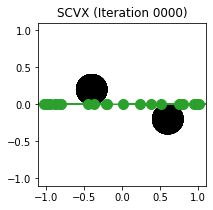

---
status optimal
DL:           45106573.470351934
actual cost:  212.05259663935314
penality      20.26028234096555
Accept: 2.00e-01 -> 4.00e-01


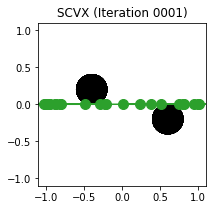

---
status optimal
DL:           80358593.75366068
actual cost:  212.0538218168733
penality      19.805442401220684
Accept: 4.00e-01 -> 8.00e-01


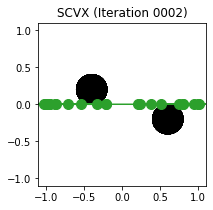

---


KeyboardInterrupt: 

In [17]:

config_scvx = dict(
    ρ0 = 0,
    ρ1 = .25,
    ρ2 = .8,
    r0 = .1,
    α = 3,
    β = 2,
    tol = 1e-1,
    pen_tol = 1e-4,
    num_iters = 32)


''' initialize '''
_x_a = [np.ones((N,2))*x_obs[0][0] for _ in range(na-1)]
for k in range(na):
#     _x_obs, _r_obs = append_obs(x_obs, r_obs, _x_a, r_buffer)
    _x, _u = cvx(x_inits[k], x_dess[k])
    _x, _u, _r = scvx(x_inits[k], x_dess[k], _x_obs, _r_obs, 
                      _x=_x, _u=_u, trial=k, **config_scvx)

In [ ]:

def not_me(na,i):
    others = list(range(na))
    del others[i]
    return others
    
for br in range(1,num_iter):
    for k in range(na):
        x_a = [x_brs[br-1][_k][0] @ T.T for _k in not_me(na, k)]
        _x_obs, _r_obs = append_obs(x_obs, r_obs, x_a, r_buffer)
        _x, _u, _r = scvx(x_inits[k], x_dess[k], _x_obs, _r_obs)#, *x_brs[br-1][k])
        x_brs[br][k] = (_x, _u, _r)
        

In [ ]:
%store x_brs